# Text Classification of StackOverflow using  Embeddings Centroids Vectors

In [1]:
import sys
import os
from os import pardir, getcwd
from os.path import join, abspath
PARENT_DIRECTORY = abspath(join(getcwd(), pardir))
sys.path.insert(0, PARENT_DIRECTORY)

import warnings
import sklearn.exceptions
import talos as ta
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from definitions import  TALOS_DIR
from app.preprocessing import load_dataset, load_embeddings, preprocess_data
from app.models import load_model, find_best_model_over_scan_logs


Using TensorFlow backend.


## Preprocessing for the loaded Dataset
1. Format into *lowercase*
2. Remove some of the *punctuation* characters
3. Remove *Numbers*
4. Remove *stopwords*
5. Remove *links*

In [2]:
data = load_dataset(load_from_pickle=True, input_ins='as_centroids')
Classes = list(data['tags'].value_counts().index)
Nclasses = len(Classes)
print(data['tags'].value_counts())
data['post'][0]

sql              2000
ruby-on-rails    2000
android          2000
angularjs        2000
asp.net          2000
c                2000
c#               2000
c++              2000
css              2000
html             2000
ios              2000
iphone           2000
java             2000
javascript       2000
jquery           2000
mysql            2000
objective-c      2000
php              2000
python           2000
.net             2000
Name: tags, dtype: int64


'causing behavior c# datetime type <pre><code>[test] public void sadness() { var datetime = datetime.utcnow assert.that(datetime is.equalto(datetime.parse(datetime.tostring()))) } </code></pre> failed  <pre><code> expected      was      </code></pre> wish know happening behind scenes tostring() etc cause behavior edit seeing jon answer  <pre><code>[test] public void newsadness() { var datetime = datetime.utcnow assert.that(datetime is.equalto(datetime.parse(datetime.tostring( )))) } </code></pre> result  <pre><code>expected      was      </code></pre> result capital small  reading docs still unclear'

## MLP classifier in Keras using not standardized **embeddings-centroids** features

 ### Hyper parameter tuning for the  model

In [3]:
# 70% Train & 30% Test
# 70% Train-Dev % 30* Train-Dev 
embeddings = load_embeddings(data, 'post', minimized=False)
model_data_ftc = preprocess_data(data, 'tags', 'post',
                                 input_ins='as_centroids',
                                 cv_split_full=0.2,
                                 cv_split_dev=0.125,
                                 embeddings=embeddings)


In [6]:
TALOS_FTC_LOG_FILENAME = 'talos_ftc_log'
talos_ftc_log_pathname = os.path.join(TALOS_DIR, TALOS_FTC_LOG_FILENAME)


###### Production configuration
ftc_model_config = {
    'visualize_proccess': [False],
    'first_neuron': [256, 512],  # First Layer
    'activation': ['relu', 'tanh'],
    'dropout': [0.2, 0.6],
    'number_of_hidden_layers': [0, 1, 2],
    'shapes':['funnel'],
    'epochs': [20, 30],
    'batch_size': [32, 64],
    'model_type': ['keras_embeddings_centroids_model'],
}

history_model_ftc = ta.Scan(model_data_ftc['x_train'],
                            model_data_ftc['y_train'],
                            x_val=model_data_ftc['x_train_dev'],
                            y_val=model_data_ftc['y_train_dev'],
                            model=load_model,
                            params=ftc_model_config,
                            grid_downsample=0.05,
                            print_params=True,
                            seed=(123),
                            dataset_name=talos_ftc_log_pathname
                            )



  0%|          | 0/4 [00:00<?, ?it/s]

{'visualize_proccess': False, 'first_neuron': 256, 'activation': 'relu', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 20, 'batch_size': 32, 'model_type': 'keras_embeddings_centroids_model'}



 25%|██▌       | 1/4 [00:40<02:00, 40.26s/it]

{'visualize_proccess': False, 'first_neuron': 256, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 30, 'batch_size': 64, 'model_type': 'keras_embeddings_centroids_model'}



 50%|█████     | 2/4 [01:15<01:17, 38.85s/it]

{'visualize_proccess': False, 'first_neuron': 512, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 1, 'shapes': 'funnel', 'epochs': 20, 'batch_size': 64, 'model_type': 'keras_embeddings_centroids_model'}



 75%|███████▌  | 3/4 [01:54<00:38, 38.66s/it]

{'visualize_proccess': False, 'first_neuron': 256, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 0, 'shapes': 'funnel', 'epochs': 30, 'batch_size': 64, 'model_type': 'keras_embeddings_centroids_model'}



100%|██████████| 4/4 [02:23<00:00, 35.90s/it]

    Finds the best model configuration set for the TF-IDF, after the Talos Scanning.

In [18]:
report_ftc = ta.Reporting(history_model_ftc)
best_model_idx = report_ftc.data['val_f1'].idxmax()
best_model_params = report_ftc.data.loc[best_model_idx].to_dict()

NameError: name 'history_model_ftc' is not defined

    Train return a TF-IDF Model with the the best configuration set.

In [8]:
# Train and Load the best model of given the tuned featured model
model_ftc_history, model_ftc = load_model(model_data_ftc['x_train'],
                                          model_data_ftc['y_train'],
                                          model_data_ftc['x_train_dev'],
                                          model_data_ftc['y_train_dev'],
                                          best_model_params)

### Visualize Model History Scores

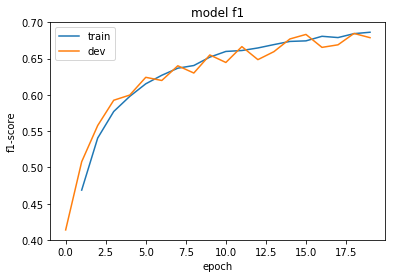

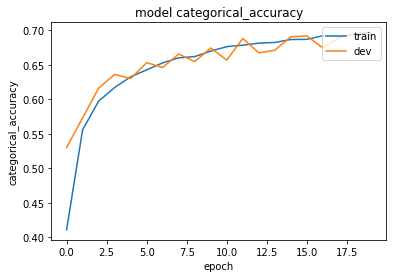

In [9]:
from app.visualization import plot_history_metrics
import matplotlib.pylab as plt

%matplotlib inline
plot_history_metrics(history_obj=model_ftc_history)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [10]:
scoref_ftc = model_ftc.evaluate(model_data_ftc['x_test'],
                               model_data_ftc['y_test'],
                               batch_size=best_model_params['batch_size'],
                               verbose=1)

print('\nTest f1: %.4f' % (scoref_ftc[1]))
print('\nTest categorical accuracy: %.4f'% (scoref_ftc[2]))

8000/8000 [==============================] - 0s 22us/step

Test f1: 0.6955

Test categorical accuracy: 0.6981


### Visualize Prediction Perfomance  model

--------------------------------------------------------------------------------
Accuracy Score: 69.81%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.706     0.552     0.620       400
           1      0.687     0.840     0.756       400
           2      0.834     0.780     0.806       400
           3      0.740     0.670     0.703       400
           4      0.868     0.757     0.809       400
           5      0.547     0.598     0.571       400
           6      0.870     0.568     0.687       400
           7      0.810     0.800     0.805       400
           8      0.539     0.718     0.616       400
           9      0.634     0.372     0.469       400
          10      0.525     0.635     0.575       400
          11      0.681     0.690     0.686       400
       

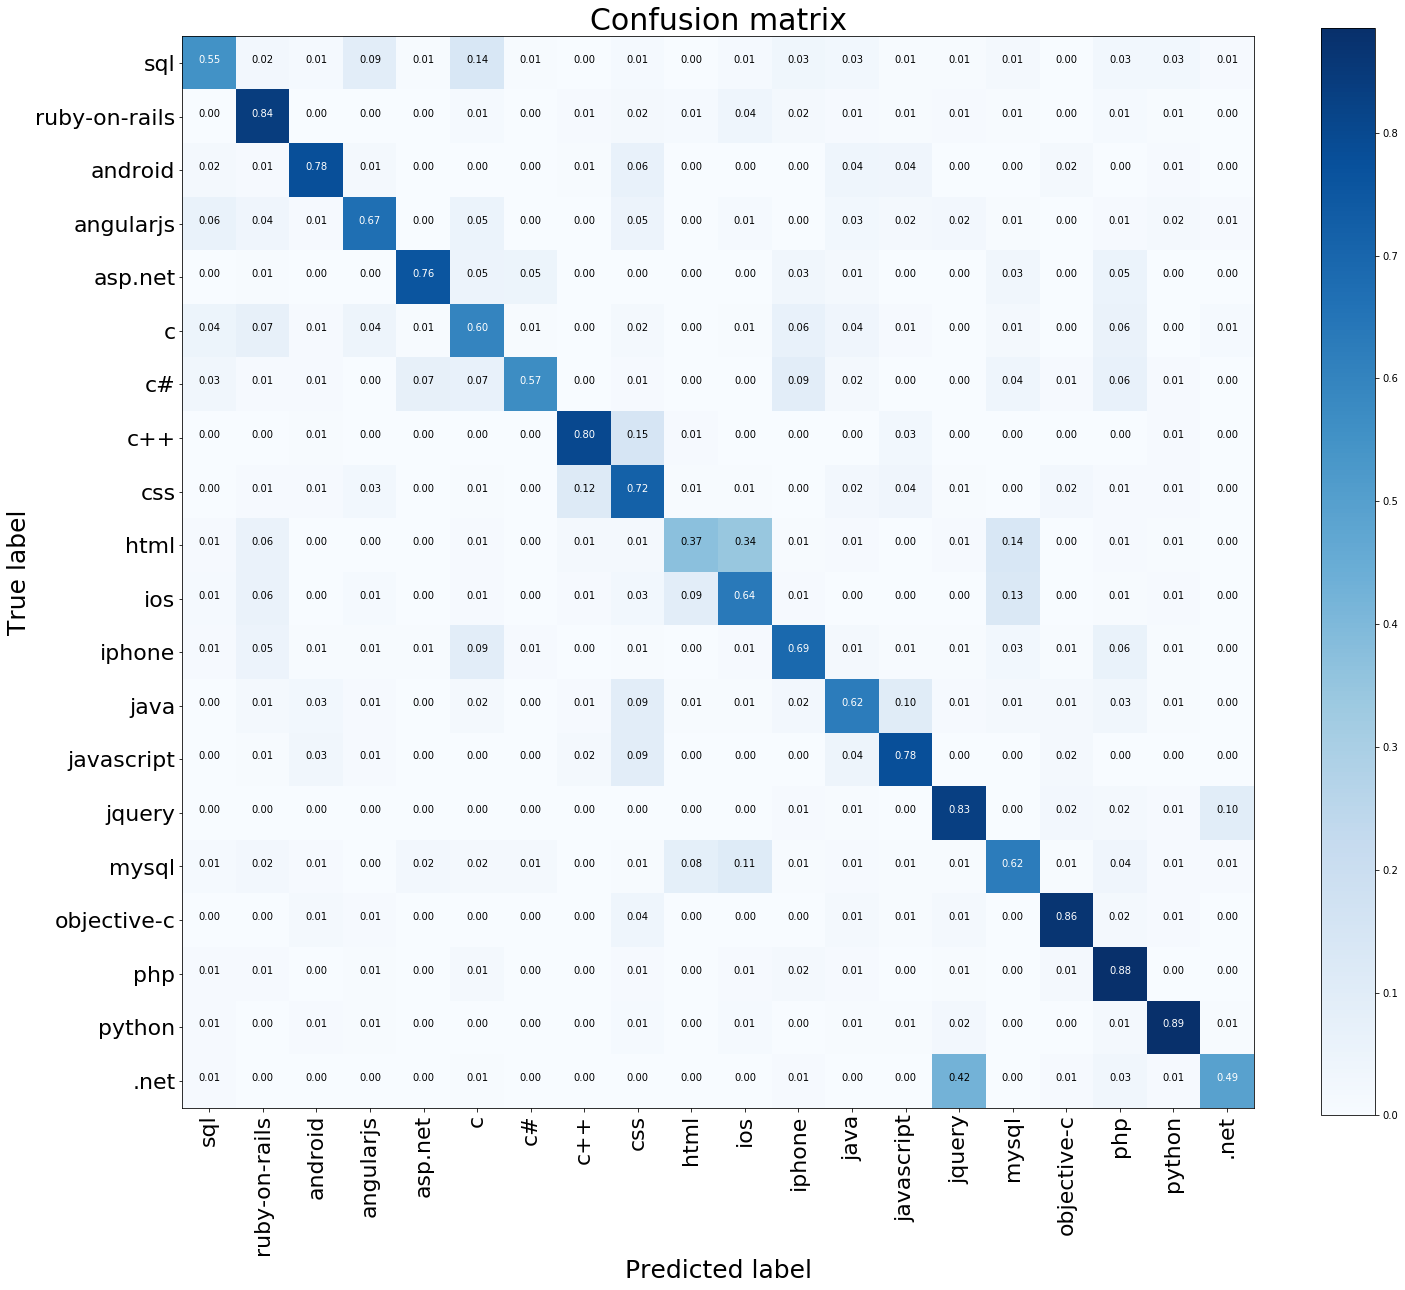

In [12]:
import numpy as np
from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_roc_curve,
                               plot_precision_recall_curve,
                               plot_confusion_matrix)
import matplotlib.pylab as plt

prediction_val_ftc = model_ftc.predict(model_data_ftc['x_test'], batch_size=best_model_params['batch_size'])

# returns each entry result to the classification with the relevant probabilities
y_pred_processed_ftc = np.array([np.argmax(val) for val in prediction_val_ftc])
y_true_processed_ftc = np.array([np.argmax(val) for val in model_data_ftc['y_test']])

# If you want to see the OneVSAll ROC Curves of each class uncomment the below line
# plot_roc_curve(model_data_ftc['y_test'], prediction_val_ftc, Classes, 1)

# If you want to see the OneVSAll Precission Recall Curves of each class, comment out the below line
# plot_precision_recall_curve(model_data_ftc['y_test'], prediction_val_ftc, Classes , 1)

# If you want to get the Classification Report, comment out the below line
create_clf_report(y_true_processed_ftc, y_pred_processed_ftc, Classes)

# If you want to get the confusion matrix,comment out the below line
plot_confusion_matrix(y_true_processed_ftc, y_pred_processed_ftc, Classes)

## MLP classifier in Keras using standardized **embeddings-centroids** features

In [ ]:
TALOS_SDR_FTC_LOG_FILENAME = 'talos_sdr_ftc_log'
talos_sdr_ftc_log_pathname = os.path.join(TALOS_DIR, TALOS_SDR_FTC_LOG_FILENAME)
from app.models import load_model
    
# Loads the dataset using centroids embeddings but now every word vector has been stardirdized.
model_data_sdr_ftc = preprocess_data(data, 'tags', 'post',
                                     input_ins='as_centroids',
                                     cv_split_full=0.2,
                                     cv_split_dev=0.125,
                                     standardize=True,
                                     embeddings=embeddings)

In [7]:
ftc_sdr_model_config = ftc_model_config.copy()
ftc_sdr_model_config.update({
    'model_type': ['keras_sdr_embeddings_centroids_model']
})



history_model_sdr_ftc = ta.Scan(model_data_sdr_ftc['x_train'],
                                model_data_sdr_ftc['y_train'],
                                x_val=model_data_sdr_ftc['x_train_dev'],
                                y_val=model_data_sdr_ftc['y_train_dev'],
                                model=load_model,
                                params=ftc_sdr_model_config,
                                grid_downsample=0.02,
                                print_params=True,
                                seed=123,
                                )


  0%|          | 0/1 [00:00<?, ?it/s]

{'visualize_proccess': False, 'first_neuron': 512, 'activation': 'tanh', 'dropout': 0.2, 'number_of_hidden_layers': 2, 'shapes': 'funnel', 'epochs': 30, 'batch_size': 64, 'model_type': 'keras_sdr_embeddings_centroids_model'}



100%|██████████| 1/1 [01:14<00:00, 74.48s/it]

    Finds the best model for the Standardized FastText Embeddings Centroids.

In [8]:
report_sdr_ftc = ta.Reporting(history_model_sdr_ftc)

#get best model configuration
best_model_sdr_ftc_idx = report_sdr_ftc.data['val_f1'].idxmax()
best_model_params_sdr_ftc = report_sdr_ftc.data.loc[best_model_sdr_ftc_idx].to_dict()
best_model_params_sdr_ftc

{'round_epochs': 30,
 'val_loss': 0.9068115501403808,
 'val_f1': 0.5913801288604736,
 'val_categorical_accuracy': 0.715,
 'loss': 0.722241087777274,
 'f1': 0.5801317994935172,
 'categorical_accuracy': 0.7576785714285714,
 'visualize_proccess': 'False',
 'first_neuron': 512,
 'activation': 'tanh',
 'dropout': 0.2,
 'number_of_hidden_layers': 2,
 'shapes': 'funnel',
 'epochs': 30,
 'batch_size': 64,
 'model_type': 'keras_sdr_embeddings_centroids_model'}

    Trains and fit the MLP Network with the standardized data using the best selected features.

In [9]:
model_sdr_ftc_history, model_sdr_ftc = load_model(model_data_sdr_ftc['x_train'],
                                                  model_data_sdr_ftc['y_train'],
                                                  model_data_sdr_ftc['x_train_dev'],
                                                  model_data_sdr_ftc['y_train_dev'],
                                                  best_model_params_sdr_ftc)

 ### Visualize Model History Scores


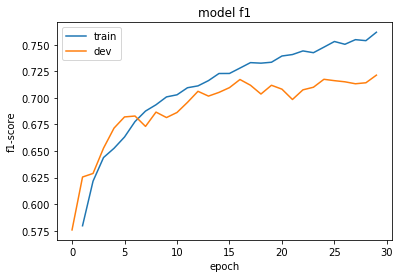

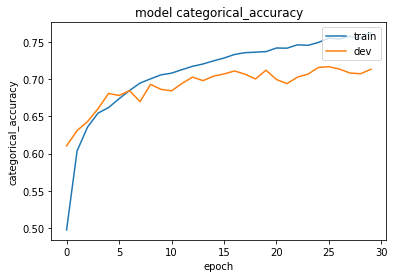

In [10]:
from app.visualization import plot_history_metrics
%matplotlib inline
plot_history_metrics(model_sdr_ftc_history)


### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [12]:
score_sdr_ftc = model_sdr_ftc.evaluate(model_data_sdr_ftc['x_test'],
                                       model_data_sdr_ftc['y_test'],
                                       batch_size=best_model_params_sdr_ftc['batch_size'],
                                       verbose=1)

print('\nTest f1: %.4f' % (score_sdr_ftc[1]))
print('\nTest categorical accuracy: %.4f'% (score_sdr_ftc[2]))

8000/8000 [==============================] - 0s 26us/step

Test f1: 0.7205

Test categorical accuracy: 0.7153


### Visualize Prediction Perfomance of standardized centroids MLP model

In [13]:
import numpy as np
from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_roc_curve,
                               plot_precision_recall_curve)
import matplotlib.pylab as plt

prediction_val_sdr_ftc = model_sdr_ftc.predict(model_data_sdr_ftc['x_test'],
                                               batch_size=best_model_params_sdr_ftc['batch_size'])

# returns each entry result to the classification with the relevant probabilities
y_pred_processed_sdr_ftc = np.array([np.argmax(val) for val in prediction_val_sdr_ftc])
y_true_processed_sdr_ftc = np.array([np.argmax(val) for val in model_data_sdr_ftc['y_test']])

# If you want to get the Classification Report, comment out the below line
create_clf_report(y_true_processed_sdr_ftc, y_pred_processed_sdr_ftc, Classes)

# If you want to get the confusion matrix,comment out the below line
plot_confusion_matrix(y_true_processed_sdr_ftc, y_pred_processed_sdr_ftc, Classes)

--------------------------------------------------------------------------------
Accuracy Score: 71.53%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.661     0.585     0.621       400
           1      0.752     0.818     0.783       400
           2      0.898     0.767     0.827       400
           3      0.639     0.708     0.671       400
           4      0.776     0.848     0.810       400
           5      0.593     0.575     0.584       400
           6      0.785     0.650     0.711       400
           7      0.820     0.830     0.825       400
           8      0.584     0.680     0.628       400
           9      0.566     0.578     0.572       400
          10      0.556     0.487     0.519       400
          11      0.703     0.723     0.713       400
       

NameError: name 'plot_confusion_matrix' is not defined